# Code to make Figure 1
- Decadal map composites over entire Ross Sea and timeseries for all winters
- Notebook by Alice DuVivier (NCAR)
- February 2023

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import sammon
import dask
import utils
from scipy.stats import linregress,pearsonr, t, ttest_ind
import cmocean
import geopandas as gpd

## Set data info

In [65]:
# set the location of the already extracted training data
sector_short = 'Ross'
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/'+sector_short+'_analysis_v4/'
path_out = path_in+'figures_outline/'
# set shape files info
fname= '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp' 

### Load data

In [3]:
# set path to the pulled data
# Note data is for larger area than only training points
# this data has been processed all the same 'time' coordinates as training data
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'

# set what variables we can plot
var_composite_in = 'aice_d'


In [4]:
# file name for training variable only here 
fin_composite = 'antarctic_data_for_som_composites_'+var_composite_in

In [5]:
# load data
ds = xr.open_mfdataset(data_path_in+fin_composite+'.nc')

In [6]:
# explicitly load data so that it doesn't take forever later on during mean
ds = ds.load()

In [7]:
var_composite_in

'aice_d'

In [8]:
ds

<xarray.Dataset>
Dimensions:    (nj: 36, ni: 320, training_times: 232300)
Coordinates:
    time       (training_times) object 1980-07-01 00:00:00 ... 2080-09-30 00:...
    member_id  (training_times) object 'r1i1001p1f1' ... 'r9i1301p1f1'
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT       (nj, ni) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
Dimensions without coordinates: training_times
Data variables:
    data       (nj, ni, training_times) float32 nan nan nan ... 0.03121 0.05833
Attributes:
    Author:    Alice DuVivier
    units:     1
    longname:  ice area  (aggregate)

### Load info with TAREA

In [9]:
# Load in the masking file
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/antarctic_ocean_masks_3.nc')


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'sh_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'socn_mask' has multiple fill values {0, -2147483647}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'Wed_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'Ross_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/work

In [10]:
# rename the coordinates for the mask
ds_masks = ds_masks.rename({'nlat':'nj','nlon': 'ni'})

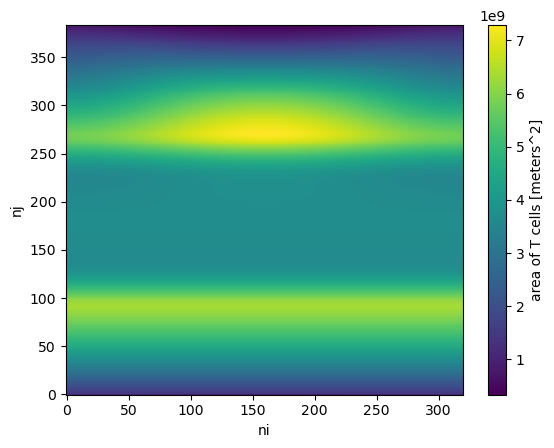

In [11]:
ds_masks.tarea.plot()

In [12]:
# set some limits for Antarctica in general
lat_max = -60
lat_min = -80

# now drop points that are masked
ds_masks_subset = ds_masks.where(((ds_masks['lat2d_T']<lat_max) & (ds_masks['lat2d_T']>lat_min)), drop=True)


In [13]:
ds_masks_subset

<xarray.Dataset>
Dimensions:     (nj: 36, ni: 320)
Dimensions without coordinates: nj, ni
Data variables: (12/13)
    sh_mask     (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    socn_mask   (nj, ni) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    Wed_mask    (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    Ross_mask   (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    Ind_mask    (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    Pac_mask    (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ...          ...
    coast_mask  (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    lon2d_T     (nj, ni) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    lat2d_T     (nj, ni) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    lon2d_U     (nj, ni) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    lat2d_U     (nj, ni) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    tarea       (nj, ni) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>

## Calculate the mean for all winter by decade

In [14]:
# calculate winter mean against which to do anomalies
mean_all = ds.data.mean(dim='training_times')

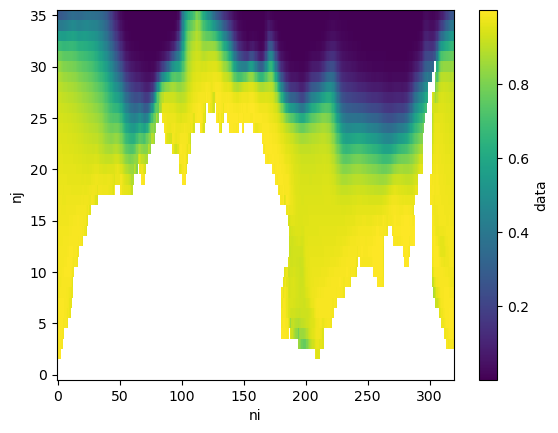

In [15]:
mean_all.plot()

In [16]:
decade_names = ['1980','1990', '2000', '2010', '2020', '2030', '2040', '2050', '2060', '2070']

In [17]:
# make numpy array to fill and specify dimensions we want
decade_array = np.zeros([len(decade_names),len(mean_all.nj),len(mean_all.ni)])

for dd in decade_names:
    print('decade: '+dd+'s')
    if dd == '1980':
        d_count = 0
        yy_st = 1980
    else: 
        d_count = d_count+1
        yy_st = yy_st + 10
    # get years for this decade
    yy_ed = yy_st + 10
    yy_all = list(range(yy_st,yy_ed,1))
    # get mean for this decade
    decade_array[d_count,:,:] = ds.data.isel(training_times=ds.time.dt.year.isin([yy_all])).mean(dim='training_times')


decade: 1980s
decade: 1990s
decade: 2000s
decade: 2010s
decade: 2020s
decade: 2030s
decade: 2040s
decade: 2050s
decade: 2060s
decade: 2070s


In [18]:
print(decade_array.shape)

(10, 36, 320)


In [19]:
# convert the numpy array to a xarray for easier plotting
decade_means = xr.DataArray(decade_array,dims=('decade','nj','ni'))

In [20]:
# set coordinate arrays
decade_means['decade'] = decade_names
decade_means['nj'] = mean_all['nj'].values
decade_means['ni'] = mean_all['ni'].values

In [21]:
decade_means

<xarray.DataArray (decade: 10, nj: 36, ni: 320)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.99997157, 0.99994606, 0.99993086, ...,        nan,
                nan,        nan],
        ...,
        [0.78941661, 0.79325372, 0.79555827, ..., 0.76086533,
         0.77479821, 0.78417474],
        [0.67341667, 0.67865223, 0.68265015, ..., 0.63166803,
         0.65369081, 0.66695356],
        [0.51917404, 0.52487558, 0.53185487, ..., 0.46516696,
         0.49314246, 0.51123202]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.99997342, 0.99994797, 0.99993289, ...,        nan,
                nan,        nan],
...
        [0.30508134, 0.30683717, 0.30385473, ..., 0.27535191,
         0.28953046, 0.29994133],
        [0.16732118, 0.16742149, 0.16521485, ..., 0.14917967,
         0.15948755, 0.16543958],
        [0.0796138 , 0.07770807, 0.07568118, ..., 0.07123185,
         0.07774213, 0.08051462]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.99999523, 0.9999904 , 0.99998522, ...,        nan,
                nan,        nan],
        ...,
        [0.21407034, 0.21540068, 0.21252318, ..., 0.18744725,
         0.19990812, 0.20936109],
        [0.11024006, 0.11026309, 0.10817686, ..., 0.09420399,
         0.10283085, 0.10828974],
        [0.047531  , 0.046364  , 0.0449232 , ..., 0.04077852,
         0.04558304, 0.04786738]]])
Coordinates:
  * decade   (decade) <U4 '1980' '1990' '2000' '2010' ... '2050' '2060' '2070'
  * nj       (nj) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
  * ni       (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

## Mask Ross Sector only

In [22]:
# mask outside Ross Sector
mean_all = mean_all.where((mean_all.coords['TLON'].values > 160) & (mean_all.coords['TLON'].values < 210))

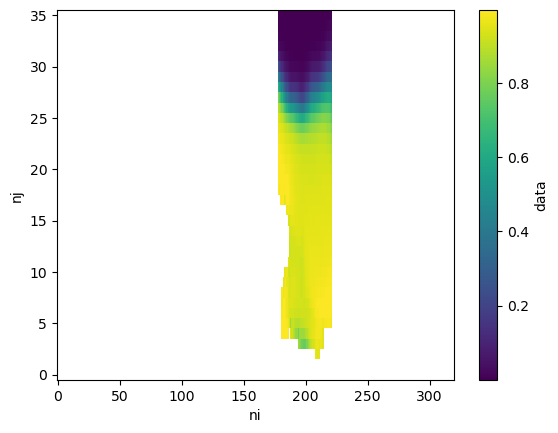

In [23]:
mean_all.plot()

In [24]:
# make the means
decade_means = decade_means.where((mean_all.coords['TLON'].values > 160) & (mean_all.coords['TLON'].values < 210))

## Calculate total ice area over this sector

In [25]:
# multiply by tarea
decade_means_tarea = decade_means * ds_masks_subset.tarea

# divide into North and South of 75S
decade_means_tarea_Nof75S = decade_means_tarea.where(mean_all.coords['TLAT'].values > -75)
decade_means_tarea_Sof75S = decade_means_tarea.where(mean_all.coords['TLAT'].values <= -75)


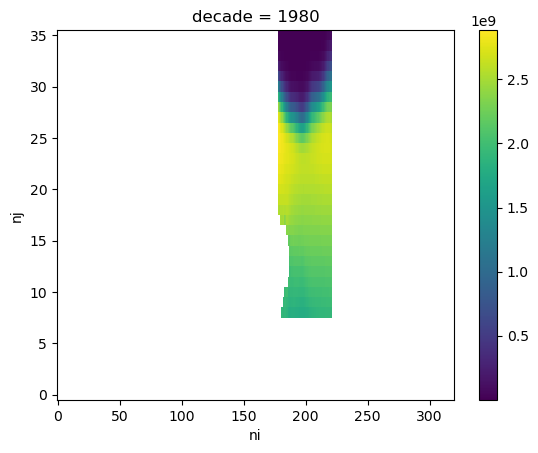

In [26]:
decade_means_tarea_Nof75S.sel(decade='1980').plot()

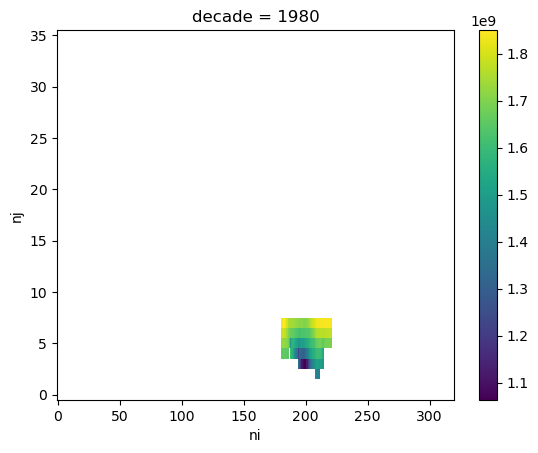

In [27]:
decade_means_tarea_Sof75S.sel(decade='1980').plot()

In [28]:
# sum over the whole region to get total area (or volume)
total_Nof75S = decade_means_tarea_Nof75S.sum(dim=['ni','nj'])
total_Sof75S = decade_means_tarea_Sof75S.sum(dim=['ni','nj'])


In [29]:
ds_masks_subset.tarea

<xarray.DataArray 'tarea' (nj: 36, ni: 320)>
dask.array<where, shape=(36, 320), dtype=float64, chunksize=(36, 320), chunktype=numpy.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    long_name:    area of T cells
    units:        meters^2
    coordinates:  TLONG TLAT

In [30]:
# convert to km2
total_Nof75S = total_Nof75S/(1000*1000)
total_Sof75S = total_Sof75S/(1000*1000)

In [31]:
# convert to millions of km2
total_Nof75S = total_Nof75S/(10**6)
total_Sof75S = total_Sof75S/(10**6)

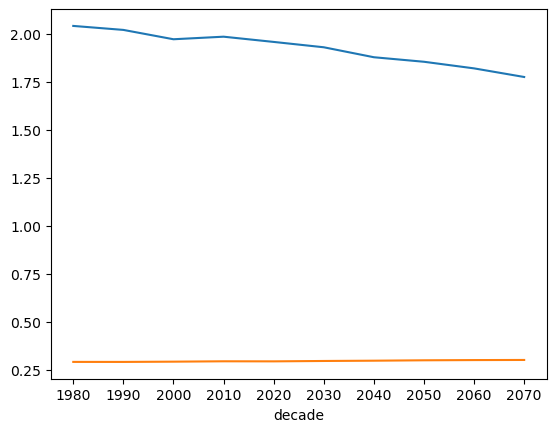

In [32]:
total_Nof75S.plot()
total_Sof75S.plot()

## Make plots

In [33]:
# Set plotting limits
lat_max = -58
lat_min = -85
lon_max = 210
lon_min = 160
lon_avg = 190

In [34]:
# deal with shape files
shdf = gpd.read_file(fname)
# This line is important. Here we convert the projection from the shapefile one to the cartopy one 
shdf = shdf.to_crs(ccrs.SouthPolarStereo())

# Shapefile projection conversion
shdf = gpd.read_file(fname)
shdf = shdf.to_crs(ccrs.SouthPolarStereo(central_longitude=lon_avg))


In [35]:
# set some labeling things
title = 'ice concentration' 
units = 'sea ice concentration (%)'
units_diff = 'change in sea ice concentration (%)'

levels_in = np.arange(0,105,5)
ticks_in = [0,10,20,30,40,50,60,70,80,90,100]
cmap_in = cmocean.cm.ice

levels_diff = np.arange(-30,35,5)
ticks_diff = [-30,-20,-10,0,10,20,30]
cmap_diff = cmocean.cm.diff
cmap_diff = cmap_diff.reversed()

# set missing value color
grey_tone = 0.5

### Spatial map of concentration

In [37]:
# bootstrap significance calculation for the difference plot
num_iterations = 10000  # this number should be somewhere between 1,000 to 10,000

# create empty array to use for percentile calculation
boot_diff_array = np.zeros((num_iterations, 
                      decade_means.isel(decade=0).shape[0],
                      decade_means.isel(decade=0).shape[1]))

# loop to bootstrap sample array of decades
for i in range(num_iterations):

    ar1 = np.random.choice(np.arange(0,10,1)) # pick random int
    ar2 = np.random.choice(np.arange(0,10,1)) # pick random int
    
    arr1 = 100 * decade_means.isel(decade=ar1) # pick random decade
    arr2 = 100 * decade_means.isel(decade=ar2) # pick random decade
    
    boot_diff_array[i,:,:] = arr1.values - arr2.values  # take diff of random decades

In [38]:
# convert the numpy array to a xarray for calculating
boot_diff = xr.DataArray(boot_diff_array,dims=('nboot','nj','ni'))

# set coordinate arrays
boot_diff['nj'] = mean_all['nj'].values
boot_diff['ni'] = mean_all['ni'].values

In [39]:
# using thresholds, we ask: "did this difference (2070-1980) occur by chance? or is it significant?"
# if it exceeds upper and lower bounds, it is likely that this did not occur by chance

# calculate unique value at all points over all bootstraps
max_thresh_all = boot_diff.quantile(0.975,dim='nboot')
min_thresh_all = boot_diff.quantile(0.025,dim='nboot')

/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


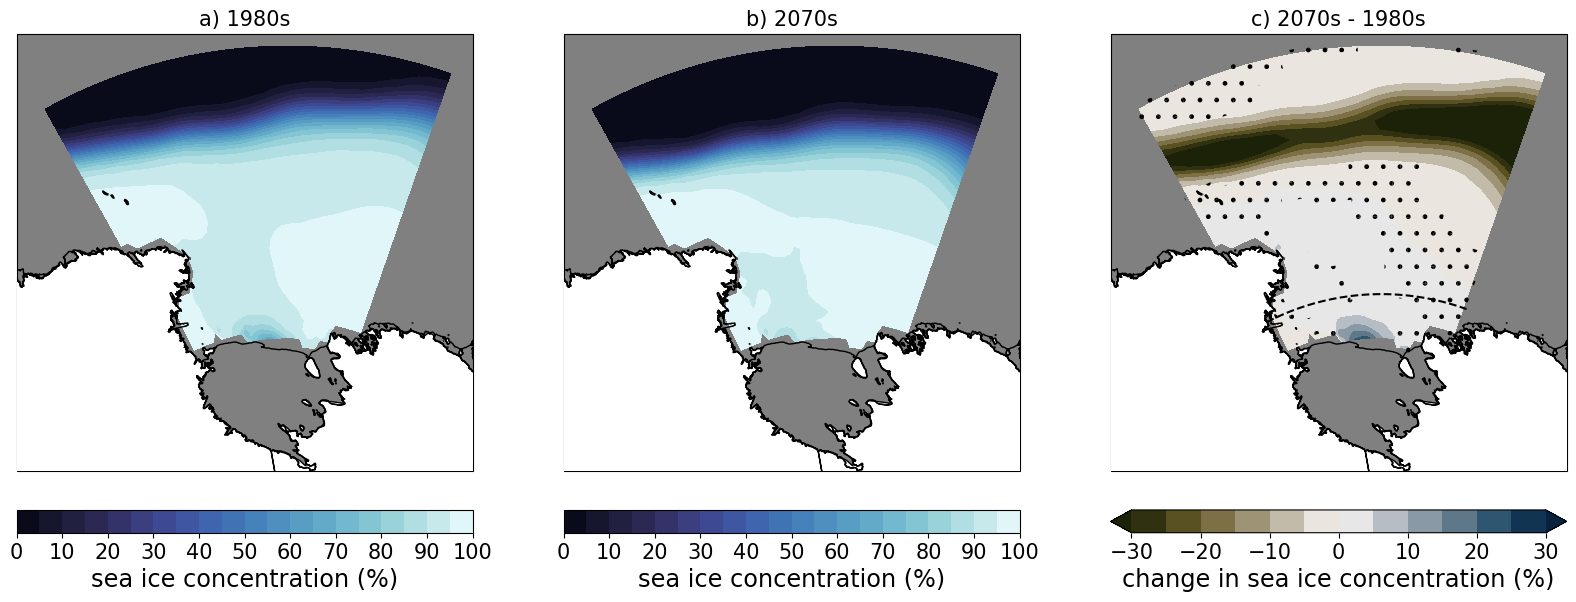

In [64]:
## 2070's difference figure
tag = '2070'
data_ctrl = 100*decade_means.sel(decade='1980')
data_in = 100*decade_means.sel(decade=tag)
data_diff = data_in - data_ctrl

# keep only data that is significantly different
sig = data_diff.where((data_diff >= max_thresh_all)|(data_diff <= min_thresh_all))
# keep only data that is NOT significancly different because we want to stipple NOT significant points
sig2 = data_diff.where((data_diff <= max_thresh_all)&(data_diff >= min_thresh_all))

# create figure
fig = plt.figure(figsize=(20,10))
fout = path_out+'fig1a'

# get lats/lons for plotting
lons = ds.TLON
lats = ds.TLAT

# plot the subplots - note it's nrow x ncol x index (starting upper left)

### mean over 1980s
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# set face colors
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
# fix variable
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_ctrl)
this = ax.contourf(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in)
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(units, fontsize='xx-large')
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
#ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('a) 1980s',fontsize=15)

### mean future
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# set face colors
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
# fix variable
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_in)
this = ax.contourf(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in)
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(units, fontsize='xx-large')
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
#ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('b) '+tag+'s',fontsize=15)

### diff
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# set face colors
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
# fix variable
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_diff)
this = ax.contourf(lon,lat,
                     field,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units_diff,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(units_diff, fontsize='xx-large')
# add significance overtop - stippling where it is NOT significant
lon, lat, field = utils.adjust_pop_grid(lons, lats, sig2)
this3 = ax.pcolor(lon,lat,
                  field,
                  transform=ccrs.PlateCarree(),
                  hatch='.',
                  alpha= 0)
# add a lines of latitude
ax.plot(np.arange(160, 210 + 1, 1),
        np.linspace(-75, -75, np.arange(160, 210 + 1, 1).shape[0]), 
        color='black', linestyle='dashed', transform=ccrs.PlateCarree())
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
#ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('c) '+tag+'s - 1980s',fontsize=15)

# Finalize figure and save
#fig.suptitle(title,fontsize=15, y=0.70)  
fig.subplots_adjust(hspace=0.2)
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

### Line plots of total ice area

In [50]:
# array against which to plot
decades = list(range(1980,2080,10))

In [51]:
decade_array = np.zeros([len(decade_names)])
decade_array[0] = 1980.0
decade_array[1] = 1990.0
decade_array[2] = 2000.0
decade_array[3] = 2010.0
decade_array[4] = 2020.0
decade_array[5] = 2030.0
decade_array[6] = 2040.0
decade_array[7] = 2050.0
decade_array[8] = 2060.0
decade_array[9] = 2070.0

North region rate -0.02866 (million km2)/decade; $r^{2}$=0.97
South region rate 0.00124 (million km2)/decade; $r^{2}$=0.97


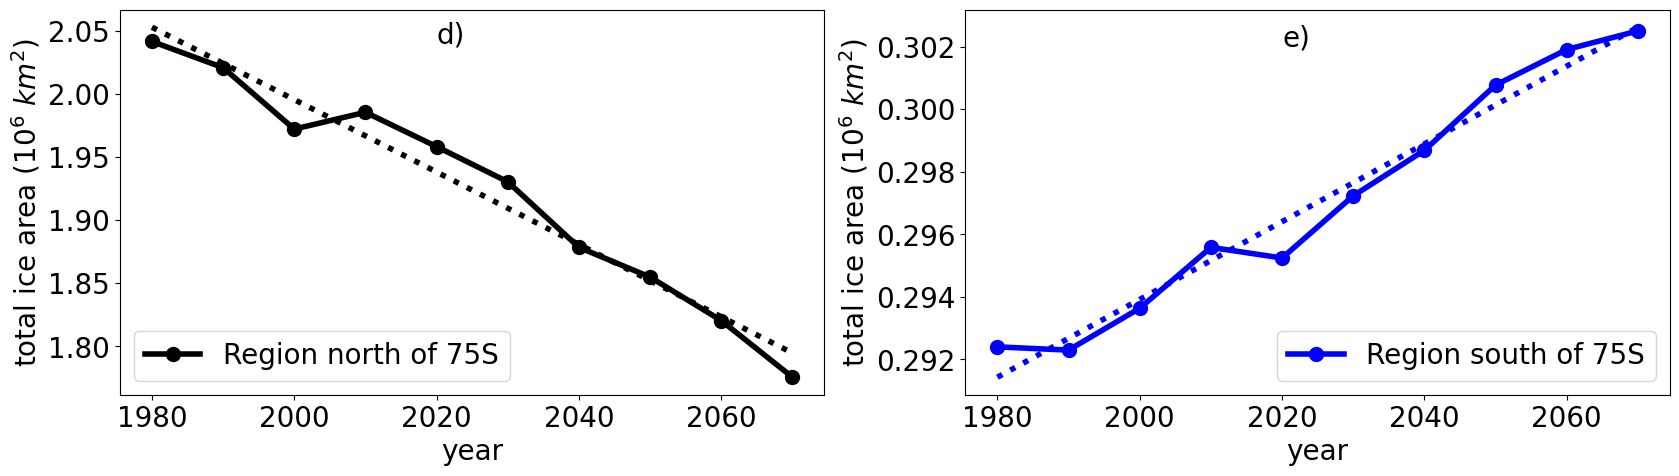

In [63]:
# create figure
fig = plt.figure(figsize=(20,5))
# now loop through months to create subpanels
fout = path_out+'fig1b'

# calculate linear regressions
x_in = decade_array    

# for North region
y_in = total_Nof75S
reg_N = linregress(x_in,y_in)
rate_N = 10*reg_N.slope
r2_N = reg_N.rvalue*reg_N.rvalue
y_reg_N = (reg_N.slope*x_in)+reg_N.intercept
tx_N = 'North region rate '+str(round(rate_N,5))+' (million km2)/decade; $r^{2}$='+str(round(r2_N,2))
print(tx_N)

# for South region
y_in = total_Sof75S
reg_S = linregress(x_in,y_in)
rate_S = 10*reg_S.slope
r2_S = reg_S.rvalue*reg_S.rvalue
y_reg_S = (reg_S.slope*x_in)+reg_S.intercept
tx_S = 'South region rate '+str(round(rate_S,5))+' (million km2)/decade; $r^{2}$='+str(round(r2_S,2))
print(tx_S)

# Make subplots - note it's nrow x ncol x index (starting upper left)
### first subplot
ax = fig.add_subplot(1,2,1)
ax.plot(decades,total_Nof75S,label="Region north of 75S",color='black',linestyle='-',linewidth=4,marker='o',markersize=10)
# plot regressions
ax.plot(x_in,y_reg_N,color='black',linestyle=':',linewidth=4)
# add label
plt.text(2020,2.04,'d)', fontsize=20)
# final plot tweaks    
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('total ice area (10$^6$ $km^{2}$)',fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower left', fontsize=20);

### second subplot
ax = fig.add_subplot(1,2,2)
ax.plot(decades,total_Sof75S,label="Region south of 75S",color='blue',linestyle='-',linewidth=4,marker='o',markersize=10)
# plot regressions
ax.plot(x_in,y_reg_S,color='blue',linestyle=':',linewidth=4)
# add label
plt.text(2020,0.302,'e)', fontsize=20)
# final plot tweaks    
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('total ice area (10$^6$ $km^{2}$)',fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower right', fontsize=20);
    
# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
